In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=be34f26cc4470219d8fcf564fd7f4df68e410bb42489aaa5470bfd1a74409493
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pyspark

In [4]:
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
import matplotlib.pyplot as plt

In [5]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [6]:
# Load the training data
train_input = spark.read.format("csv").option("header", True).option("inferSchema", True).load("/content/drive/MyDrive/kaggle_ts2/InputTrain.csv")

In [7]:
test_input = spark.read.format("csv").option("header", True).option("inferSchema", True).load("/content/drive/MyDrive/kaggle_ts2/InputTest.csv")

In [8]:
# Load the training labels
train_label_dishwasher = spark.read.format("csv").option("header", True).option("inferSchema", True).load("/content/drive/MyDrive/kaggle_ts2/StepTwo_LabelTrain_Dishwasher.csv")

In [9]:
train_label_kettle = spark.read.format("csv").option("header", True).option("inferSchema", True).load("/content/drive/MyDrive/kaggle_ts2/StepTwo_LabelTrain_Kettle.csv")

In [10]:
train_label_microwave = spark.read.format("csv").option("header", True).option("inferSchema", True).load("/content/drive/MyDrive/kaggle_ts2/StepTwo_LabelTrain_Microwave.csv")

In [11]:
train_label_tumbledryer = spark.read.format("csv").option("header", True).option("inferSchema", True).load("/content/drive/MyDrive/kaggle_ts2/StepTwo_LabelTrain_TumbleDryer.csv")

In [12]:
train_label_washingmachine = spark.read.format("csv").option("header", True).option("inferSchema", True).load("/content/drive/MyDrive/kaggle_ts2/StepTwo_LabelTrain_WashingMachine.csv")

In [13]:
# Assemble the time series in the input and labels into one column named "features"
time_series_assembler = VectorAssembler(inputCols=train_input.columns[2:], outputCol="features")
train_input_combined = time_series_assembler.transform(train_input)
train_label_kettle = time_series_assembler.transform(train_label_kettle)
train_label_washingmachine = time_series_assembler.transform(train_label_washingmachine)
train_label_dishwasher = time_series_assembler.transform(train_label_dishwasher)
train_label_tumbledryer = time_series_assembler.transform(train_label_tumbledryer)
train_label_microwave = time_series_assembler.transform(train_label_microwave)

In [14]:
time_series_assembler = VectorAssembler(inputCols=train_input.columns[2:], outputCol="features")

In [15]:
test_input_combined = time_series_assembler.transform(test_input)
test_data = test_input_combined.select('features').toPandas()['features']

Here we get the label data for each of the appliances as Python two dimensional lists

In [16]:
# Obtain the concatenated values of the labels for the Dish Washer
dishwasher_label = train_label_dishwasher.select('features').toPandas()['features']
# Turn it into an python 2 dimensional list
dishwasher_label = [dishwasher_label[i].toArray().tolist() for i in range(len(dishwasher_label))]
dishwasher_label = [[int(i) for i in l] for l in dishwasher_label]
# Obtain the concatenated values of the labels for the Washing Machine
washingmachine_label = train_label_washingmachine.select('features').toPandas()['features']
# Turn it into an python 2 dimensional list 
washingmachine_label = [washingmachine_label[i].toArray().tolist() for i in range(len(washingmachine_label))]
washingmachine_label = [[int(i) for i in l] for l in washingmachine_label]
# Obtain the concatenated values of the labels for the Tumble Dryer
tumblerdryer_label = train_label_tumbledryer.select('features').toPandas()['features']
# Turn it into an python 2 dimensional list
tumblerdryer_label = [tumblerdryer_label[i].toArray().tolist() for i in range(len(tumblerdryer_label))]
tumblerdryer_label = [[int(i) for i in l] for l in tumblerdryer_label]
# Obtain the concatenated values of the Microwave
microwave_label = train_label_microwave.select('features').toPandas()['features']
# Turn it into an python 2 dimensional list
microwave_label = [microwave_label[i].toArray().tolist() for i in range(len(microwave_label))]
microwave_label = [[int(i) for i in l] for l in microwave_label]
# Obtain the concatenated values of the Kettle
kettle_label = train_label_kettle.select('features').toPandas()['features']
# Turn it into an python 2 dimensional list
kettle_label = [kettle_label[i].toArray().tolist() for i in range(len(kettle_label))]
kettle_label = [[int(i) for i in l] for l in kettle_label]

In [17]:
len(kettle_label)

10421

In the following cell we combine the 5 labels into one value between 0 and 31. The activation states of each of the 5 appliances are used as the bits of the combined label.

In [18]:
# washingmachine, dishwasher, tumble dryer, microwave and kettle
labels_combined = [[int(f'{wa}{dis}{tumb}{mic}{ket}', 2) for (wa,dis,mic,ket,tumb) in zip(washingmachine_label[i], dishwasher_label[i], microwave_label[i], kettle_label[i], tumblerdryer_label[i])] for i in range(len(kettle_label))]

In [19]:
import numpy as np 

In [20]:
time_series_input = train_input_combined.select('features').toPandas()['features']

In [21]:
integer_time_series_input = [time_series_input[i].toArray().tolist() for i in range(len(time_series_input))]
integer_time_series_input = [[int(i) for i in l] for l in integer_time_series_input]

In [22]:
integer_test_data = [test_data[i].toArray().tolist() for i in range(len(test_data))]
integer_test_data = [[int(i) for i in l] for l in integer_test_data]

In [ ]:
integer_time_series_input[:1]

In [24]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray',
          'olive', 'cyan', 'magenta', 'lime', 'gold', 'navy', 'teal', 'maroon']

In [25]:
classes = ['no machine', 'tumble', 'kettle', 'tumble+kettle', 'micro.', 'micro.+tumble', 'micro.+kettle', 
          'micro.+tumble+kettle', 'dish.', 'dish.+tumble', 'dish.+kettle', 'dish.+tumble+kettle', 'dish.+micro.', 
          'dish.+micro.+tumble', 'dish.+micro.+kettle', 'dish.+micro.+tumble+kettle', 'wash.', 'wash.+tumble', 
          'wash.+kettle', 'wash.+tumble+kettle', 'wash.+micro.', 'wash.+micro.+tumble', 'wash.+micro.+kettle', 
          'wash.+micro.+tumble+kettle', 'wash.+dish.', 'wash.+dish.+tumble', 'wash.+dish.+kettle', 'wash.+dish.+tumble+kettle', 
          'wash.+dish.+micro.', 'wash.+dish.+micro.+tumble', 'wash.+dish.+micro.+kettle', 'wash.+dish.+micro.+tumble+kettle']

In [26]:
len(classes) 

32

In [27]:
# an example for test
labels = np.array(labels_combined[1415])

In [ ]:
washingmachine_indexes = set([i for i in range(len(labels_combined)) for j in range(2160) if labels_combined[i][j] == 16]); washingmachine_indexes;

In [ ]:
dishwasher_indexes = set([i for i in range(len(labels_combined)) for j in range(2160) if labels_combined[i][j] == 8]); dishwasher_indexes;

In [ ]:
tumble_indexes = set([(i, j) for i in range(len(labels_combined)) for j in range(2160) if labels_combined[i][j] == 4]); tumble_indexes;

In [31]:
microwave_indexes = set([i for i in range(len(labels_combined)) for j in range(2160) if labels_combined[i][j] == 2]); microwave_indexes;


*   2100 (only dishwasher)

*   2300 interesting

*   ligne 2303: montee de 2305.0 et descente de 2155.0 --> dishwasher, ela = 2
*  montee de 1167.0, descente de -1355.0: microwave

* montee de 2885.0 descente -2648.0: kettle

* montee et descentes frequentes d'environ 1283.0-1347.0 --> tumble dryer
* montee de 150 aa 200/400: washingmachine

* zero signal at all at lines: 4789-4830+


In [32]:
def detect(time_series, which="wa", thresh=20, el=1):
  diff = differential_series(time_series_input[line][inf:sup], elasticity=el, threshold_min=thresh, threshold_max=thresh)
  appliances = {'wa': [300, 50], 'di':[2350.0, 50], 'tu':[1300, 50], 'mi': [1200, 50], 'ke': [2800, 50]}
  margin = 50
  diff_filtered = []
  masks = []
  for i in range(len(diff)):
    center = appliances[which][0]
    margin = appliances[which][1]
    value = diff[i] if center-margin < diff[i] < center+margin or \
                      -center-margin < diff[i] < -center+margin else 0
    diff_filtered.append(value)
    masks.append(1 if value > 0 else -1 if value < 0 else 0)
  # for v in masks:
  #   if v != 0:
  #     print(v)
  return masks
  """
  ligne 2303: montee de 2305.0 et descente de 2155.0 --> dishwasher
*  montee de 1167.0, descente de -1355.0: microwave

* montee de 2885.0 descente -2648.0: kettle

* montee et descentes frequentes d'environ 1283.0-1347.0 --> tumble dryer
* montee de 150 aa 200/400: washingmachine

* zero signal at all at lines: 4789-4830+
  """


In [33]:
def diff_per_appliance(time_series, el=1):
  res = [[]]*5
  diffs = []
  for tm in time_series:
    diffs.append(differential_series(tm, elasticity=el))
  from math import sqrt
  for i in range(5):
    code = 1<<i
    avg_plus = 0
    std_plus = 0
    num_plus = 0
    avg_minus = 0
    std_minus = 0
    num_minus = 0
    print(f'for {i}')
    for j in range(len(time_series)):
      for k in range(2160-el):
        if labels_combined[j][k]&code != labels_combined[j][k+el]&code:
          #print(f"change at line {j} cool {k} for appliance {i}")
          #print(labels_combined[j][k], " --> ", code, " --> ", labels_combined[j][k+1])
            #print(f"code {code}")
          if diffs[j][k] > 0:
            #print(f'for {diffs[j][k]}')
            avg_plus += diffs[j][k]
            std_plus += diffs[j][k]*diffs[j][k]
            num_plus += 1
          elif diffs[j][k] < 0:
            avg_minus += diffs[j][k]
            std_minus += diffs[j][k]*diffs[j][k]
            num_minus += 1
          #if k in range(1,len(diffs[0])-el): print(f"trois diff for {i}: {diffs[j][k-el]}, {diffs[j][k]}, {diffs[j][k+el]}")
          res[i].append(diffs[j][k])
    # avg_plus /= num_plus
    # std_plus = sqrt(std_plus/num_plus - avg_plus*avg_plus)
    # avg_minus /= num_minus
    # std_minus = sqrt(std_minus/num_minus - avg_minus*avg_minus)
    # res[i] = [avg_plus, std_plus, avg_minus, std_minus]
  return res

In [34]:
def differential_series(time_series, threshold_min=100, threshold_max=100, elasticity=1):
  differential = []
  for i in range(len(time_series)-elasticity):
    delta = time_series[i+elasticity]-time_series[i]
    delta = 0 if -threshold_min <= delta <= threshold_max else delta
    differential.append(delta)
  return differential 

In [ ]:
diff_per_appl = diff_per_appliance(time_series_input, el=1)

In [39]:
# predictions = []
# for t in range(len(time_series_input)):
#   line = time_series_input[t]
#   for i in range(len(lab)):
#     mask = detect(line, which=lab[i], el=el)
#     fig, ax = plt.subplots(figsize=(8, 0.5))
#     ax.plot(mask, label=f'detect "{appl}"', c='brown')
#     plt.axis('off')
#     plt.legend()
#     plt.show()

#     pred = []
#     val = 0
#     ones = 100
#     o = 0
#     for i in range(len(mask)):
#       if mask[i] > 0 and o <= 0:
#         val = 1
#         o = ones
#       elif o == 0:
#         val = 0
#       o -= 1
#       pred.append(val)
#     print(pred)

In the following cell we perform some exploration of the time series dataset

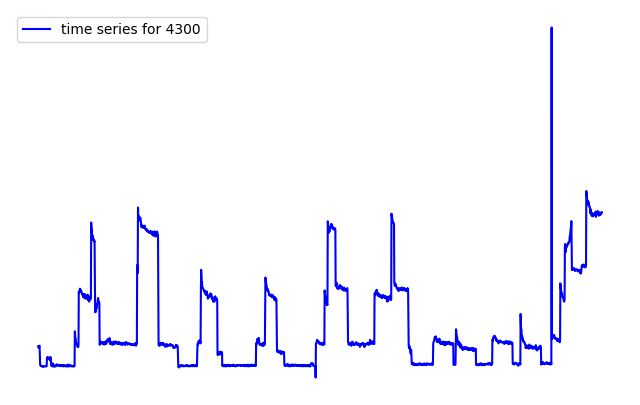

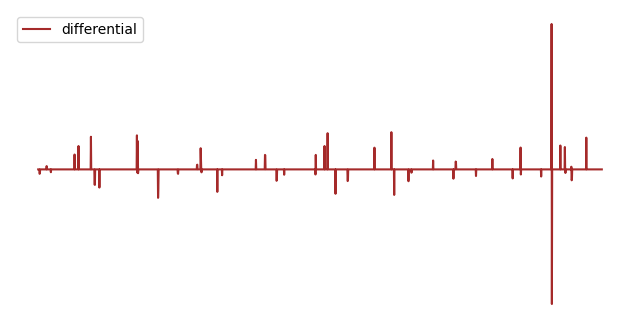

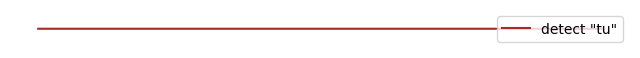

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

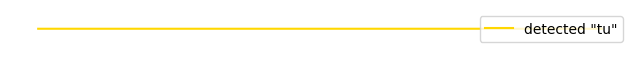

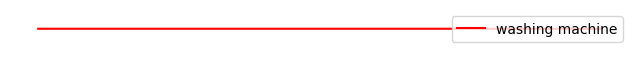

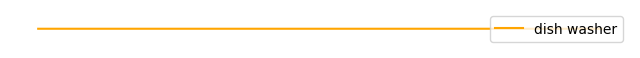

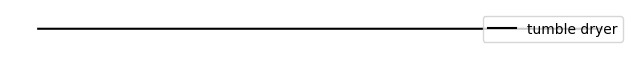

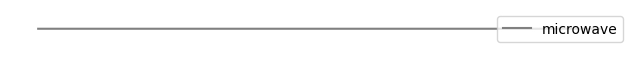

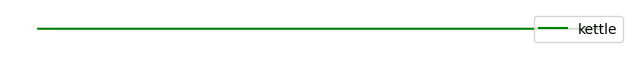

In [40]:
import seaborn as sns
# class_var = np.concatenate(([f'Class {i+1}' for i in range(16)]))

# Define a list of 16 colors
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray',
          'olive', 'cyan', 'magenta', 'lime', 'gold', 'navy', 'teal', 'maroon']
colors *= 2

line = 4300
inf = 0
sup = 2000

# The time series for 6 hours window
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time_series_input[line][inf:sup], label=f'time series for {line}', c='blue')
plt.axis('off')
plt.legend()
plt.show()
#print(time_series_input[line][inf:sup])

# The differential of values 
thresh = 10
el = 1
diff = differential_series(time_series_input[line][inf:sup], elasticity=el, threshold_min=thresh, threshold_max=thresh)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(diff, label='differential', c='brown')
plt.axis('off')
plt.legend()
plt.show()

appl = 'tu'
mask = detect(time_series_input[line][inf:sup], which=appl, el=el)
fig, ax = plt.subplots(figsize=(8, 0.5))
ax.plot(mask, label=f'detect "{appl}"', c='brown')
plt.axis('off')
plt.legend()
plt.show()

pred = []
val = 0
ones = 100
o = 0
for i in range(len(mask)):
  if mask[i] > 0 and o <= 0:
    val = 1
    o = ones
  elif o == 0:
    val = 0
  o -= 1
  pred.append(val)
print(pred)

fig, ax = plt.subplots(figsize=(8, 0.5))
ax.plot(pred, label=f'detected "{appl}"', c='gold')
plt.axis('off')
plt.legend()
plt.show()

# The differential of values
# thresh = 10
# diff = differential_series(time_series_input[line][inf:sup], elasticity=3, threshold_min=thresh, threshold_max=thresh)
# fig, ax = plt.subplots(figsize=(8, 2))
# ax.plot(diff, label='differential', c='teal')
# plt.axis('off')
# plt.legend()
# plt.show()

# # The differential of values
# thresh = 10
# diff = differential_series(time_series_input[line][inf:sup], elasticity=5, threshold_min=thresh, threshold_max=thresh)
# fig, ax = plt.subplots(figsize=(8, 2))
# ax.plot(diff, label='differential', c='lime')
# plt.axis('off')
# plt.legend()
# plt.show()

# Activation indicators for washing machine
fig, ax = plt.subplots(figsize=(8, 0.5))
ax.plot(washingmachine_label[line][inf:sup], label='washing machine', c='red')
plt.axis('off')
plt.legend()
plt.show()

# Activation indicators for dish washer
fig, ax = plt.subplots(figsize=(8, 0.5))
ax.plot(dishwasher_label[line][inf:sup], label='dish washer', c='orange')
plt.axis('off')
plt.legend()
plt.show()

# Activation indicators for tumble dryer
fig, ax = plt.subplots(figsize=(8, 0.5))
ax.plot(tumblerdryer_label[line][inf:sup], label='tumble dryer', c='black')
plt.axis('off')
plt.legend()
plt.show()

# Activation indicators for microwave
fig, ax = plt.subplots(figsize=(8, 0.5))
ax.plot(microwave_label[line][inf:sup], label='microwave', c='gray')
plt.axis('off')
plt.legend()
plt.show()

# Activation indicators for kettle
fig, ax = plt.subplots(figsize=(8, 0.5))
ax.plot(kettle_label[line][inf:sup], label='kettle', c='green')
plt.axis('off')
plt.legend()
plt.show()

In [ ]:
print(diff)

In [ ]:
detected = detect(time_series_input[line], which="wa")

In [42]:
# pred = []
# for i in range(len(detected)):
#   if detected[i] > 0:
#     val = 1
#   else:
#     val = 0
#   pred.append(val)

In the following notebook cell, we compute the 

In [43]:
from collections import defaultdict

hist = defaultdict(lambda: defaultdict(lambda: 0))
for i in range(len(time_series_input)):
  # print(i)
  for j in range(2160):
    u = labels_combined[i][j]
    v = int(time_series_input[i][j])
    # print(f'u = {u}, v = {v}')
    hist[u][v] += 1

In [44]:
# Sur l'ensemble des donnees d'entrainement, on a (en termes de nombres de points de donnees):
s = 0
total = 10421*2160
for i in range(len(hist)):
  sum = np.sum([v for v in hist[i].values()])
  s += sum
  print(f"{classes[i]}  -->  {sum*100/total}")
print("Sum: ", s)
print("Total: ", 10421*2160)

no machine  -->  93.54887922179928
tumble  -->  0.33223068092562386
kettle  -->  0.11469895190267515
tumble+kettle  -->  0.0029232283814377663
micro.  -->  0.36890875617965146
micro.+tumble  -->  0.0071525800822413435
micro.+kettle  -->  0.002110233254077415
micro.+tumble+kettle  -->  5.331115589248206e-05
dish.  -->  2.6442022340928397
dish.+tumble  -->  0.011115376003582509
dish.+kettle  -->  0.00439817036112977
dish.+tumble+kettle  -->  9.773711913621712e-05
dish.+micro.  -->  0.024243248142106218
dish.+micro.+tumble  -->  0.0005331115589248206
dish.+micro.+kettle  -->  9.773711913621712e-05
dish.+micro.+tumble+kettle  -->  0.0
wash.  -->  2.540192168946607
wash.+tumble  -->  0.015646824254443484
wash.+kettle  -->  0.00866750542885271
wash.+tumble+kettle  -->  0.0001777038529749402
wash.+micro.  -->  0.11669367765231886
wash.+micro.+tumble  -->  0.0030476210785202245
wash.+micro.+kettle  -->  0.0009285026317940626
wash.+micro.+tumble+kettle  -->  3.109817427061453e-05
wash.+dish.  -

In [45]:
from collections import defaultdict

hist = defaultdict(lambda: defaultdict(lambda: 0))
for i in range(len(time_series_input)):
  # print(i)
  for j in range(2160):
    u = labels_combined[i][j]
    v = int(time_series_input[i][j])
    # print(f'u = {u}, v = {v}')
    hist[u][v] += 1

# Sur l'ensemble des donnees d'entrainement, on a (en termes de nombres de points de donnees):
s = 0
total = 10421*2160
for i in range(len(hist)):
  sum = np.sum([v for v in hist[i].values()])
  s += sum
  print(f"{classes[i]}  -->  {sum*100/total}")
print("Sum: ", s)
print("Total: ", 10421*2160)

# Sur l'ensemble des donnees d'entrainement, Observe les valeurs de load curve associées à chacune des
# differentes combinaisons d'equipements possibles
for i in range(len(hist)):
  #print("combinations of appliance")
  print(classes[i], ' --> ', sorted(hist[i].items(), key=lambda x: x[1], reverse=True))

no machine  -->  93.54887922179928
tumble  -->  0.33223068092562386
kettle  -->  0.11469895190267515
tumble+kettle  -->  0.0029232283814377663
micro.  -->  0.36890875617965146
micro.+tumble  -->  0.0071525800822413435
micro.+kettle  -->  0.002110233254077415
micro.+tumble+kettle  -->  5.331115589248206e-05
dish.  -->  2.6442022340928397
dish.+tumble  -->  0.011115376003582509
dish.+kettle  -->  0.00439817036112977
dish.+tumble+kettle  -->  9.773711913621712e-05
dish.+micro.  -->  0.024243248142106218
dish.+micro.+tumble  -->  0.0005331115589248206
dish.+micro.+kettle  -->  9.773711913621712e-05
dish.+micro.+tumble+kettle  -->  0.0
wash.  -->  2.540192168946607
wash.+tumble  -->  0.015646824254443484
wash.+kettle  -->  0.00866750542885271
wash.+tumble+kettle  -->  0.0001777038529749402
wash.+micro.  -->  0.11669367765231886
wash.+micro.+tumble  -->  0.0030476210785202245
wash.+micro.+kettle  -->  0.0009285026317940626
wash.+micro.+tumble+kettle  -->  3.109817427061453e-05
wash.+dish.  -

In [46]:
np.sum([len(hist[i]) for i in range(len(hist))])

51219

In [52]:
# Sur l'ensemble des donnees d'entrainement, Observe les valeurs de load curve associées à chacune des
# differentes combinaisons d'equipements possibles
for i in range(len(hist)):
  print(classes[i], ' --> ', sorted(hist[i].items(), key=lambda x: x[1], reverse=True)[:2], "\\\\ \hline")

no machine  &  [(180, 219410), (159, 206503)] \\ \hline
tumble  &  [(6000, 685), (2993, 119)] \\ \hline
kettle  &  [(6000, 307), (1511, 62)] \\ \hline
tumble+kettle  &  [(6000, 73), (4444, 6)] \\ \hline
micro.  &  [(6000, 592), (401, 129)] \\ \hline
micro.+tumble  &  [(6000, 184), (4834, 8)] \\ \hline
micro.+kettle  &  [(6000, 87), (4758, 9)] \\ \hline
micro.+tumble+kettle  &  [(6000, 7), (4154, 2)] \\ \hline
dish.  &  [(2169, 242689), (2729, 4392)] \\ \hline
dish.+tumble  &  [(6000, 212), (5258, 9)] \\ \hline
dish.+kettle  &  [(6000, 39), (3950, 5)] \\ \hline
dish.+tumble+kettle  &  [(6000, 21), (5943, 1)] \\ \hline
dish.+micro.  &  [(6000, 197), (5213, 14)] \\ \hline
dish.+micro.+tumble  &  [(6000, 24), (5120, 4)] \\ \hline
dish.+micro.+kettle  &  [(6000, 9), (5908, 1)] \\ \hline
dish.+micro.+tumble+kettle  &  [(0, 0), (1, 0)] \\ \hline
wash.  &  [(6000, 3696), (602, 813)] \\ \hline
wash.+tumble  &  [(6000, 134), (3650, 9)] \\ \hline
wash.+kettle  &  [(6000, 113), (2126, 9)] \\ \hlin

In [48]:
all_keys = set()
for i in hist:
  all_keys.update(hist[i].keys())

In [ ]:
#all_keys

In [53]:
maxi_val = defaultdict(int)
for i in range(6001):
  max = 0
  for cl in hist:
    if hist[cl][i] > max:
      maxi_val[i] = cl
      max = hist[cl][i]

In [ ]:
maxi_val[6]

In [54]:
def predict(test_data):
  result = []
  for line in test_data:
    for val in line:
      result.append(maxi_val[val])
  return result

In [55]:
test = [test_data[i].toArray().tolist() for i in range(len(test_data))]
test = [[int(i) for i in l] for l in test_data]

In [56]:
predictions = predict(test); len(predictions)

5374080

In [59]:
# washing machine, 
# dishwasher, tumble dryer, microwave and kettle
# {wa}{dis}{mic}{ket}{tumb}
predictions = [[j, (i>>4)&1, (i>>3)&1, (i>>2)&1, (i>>1)&1, i&1] for i, j in zip(predictions, list(range(len(predictions))))]

In [60]:
import pandas as pd

In [61]:
predictions = pd.DataFrame(predictions, columns=['Index', 'Washing Machine', 'Dishwasher', 'Tumble Dryer', 'Microwave', 'Kettle'])

In [62]:
predictions.to_csv('output2.csv', index=False)

In [63]:
print(predictions)

           Index  Washing Machine  Dishwasher  Tumble Dryer  Microwave  Kettle
0              0                0           0             0          0       0
1              1                0           0             0          0       0
2              2                0           0             0          0       0
3              3                0           0             0          0       0
4              4                0           0             0          0       0
...          ...              ...         ...           ...        ...     ...
5374075  5374075                0           0             0          0       0
5374076  5374076                0           0             0          0       0
5374077  5374077                0           0             0          0       0
5374078  5374078                0           0             0          0       0
5374079  5374079                0           0             0          0       0

[5374080 rows x 6 columns]


In [64]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Generate random data
# x = np.random.rand(100)
# y = np.random.rand(100)

# for label in range(32):
#   x = hist[label].keys()
#   y = hist[label].values()

#   print(f"HISTOGRAM FOR LABEL {label}")
#   # Create a scatter plot with masked points colored differently using Seaborn
#   plt.scatter(x=x, y=y, label=f"HISTOGRAM FOR {classes[label]}", s=1)

#   plt.legend()
#   plt.show()

In [ ]:
train_input_combined.select('features').show(truncate=200)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Generate sample data
# x = np.arange(0, 10, 0.1)
# y = np.sin(x)
# colors = np.random.rand(len(x))

# # Create line plot with colored markers
# plt.plot(x, y, 'o', color=colors)

# # Show plot
# plt.show()
